# MCMC Analysis and Plots
This notebook is to analyze MCMC walk data and produce relevant results plots

In [1]:
#Set up notebook and load some R68 constants (V, eps, etc.)
exec(open("nb_setup.py").read())#Is there a better way to do this?
from constants import *

../mplstyles
3.1.1
/data/chocula/mast/cdms/analysis/run068/R68_paper2019/mplstyles


In [6]:
#Turns out we need the helper functions to still be defined since the stored samplers rely on them.

In [19]:
def LindFit_helper(params):
    return np.sum(calcGOF(model='Lind', params=params, bin_low=5, bin_high=101, GOF='chisq'))

In [8]:
#Load the MCMC data
import pickle as pkl

fname='data/mcmc_Lind_8walk_5000step_norm_v1.pkl'
sampler_l=pkl.load(open(fname,'rb'))

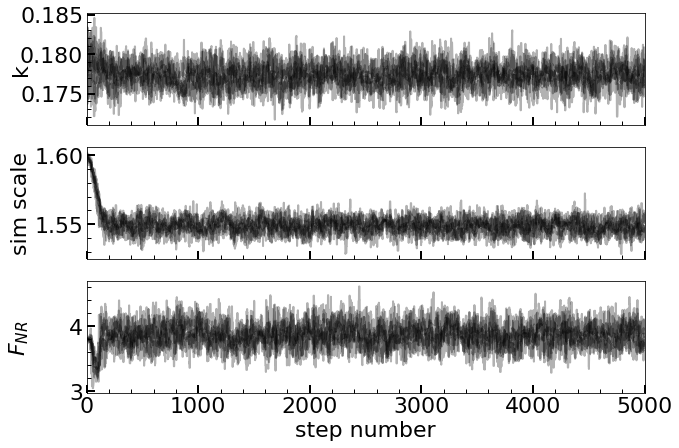

In [22]:
#Look at the chain of parameter values
labels_l = [r'k', r'sim scale', r'$F_{NR}$']

samples_l = sampler_l.get_chain()
ndim_l = samples_l.shape[2]

fig, axes = plt.subplots(ndim_l, figsize=(10, 7), sharex=True)
for i in range(ndim_l):
    ax = axes[i]
    ax.plot(samples_l[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples_l))
    #ax.set_ylim(0, 5)
    ax.set_ylabel(labels_l[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [26]:
#Get the sample autocorrelation times for each variable and use the largest one
tau_l=sampler_l.get_autocorr_time()
print(tau_l)
avgtau_l=round(np.max(tau_l))
print(avgtau_l)

[44.95659293 87.33115101 56.22285996]
87.0


In [27]:
#Discard a few times tau as burn-in and thin by tau/2
flat_samples_l = sampler_l.get_chain(discard=int(2.*avgtau_l), thin=int(round(avgtau_l/2.)), flat=True)
print(flat_samples_l.shape)

(872, 3)


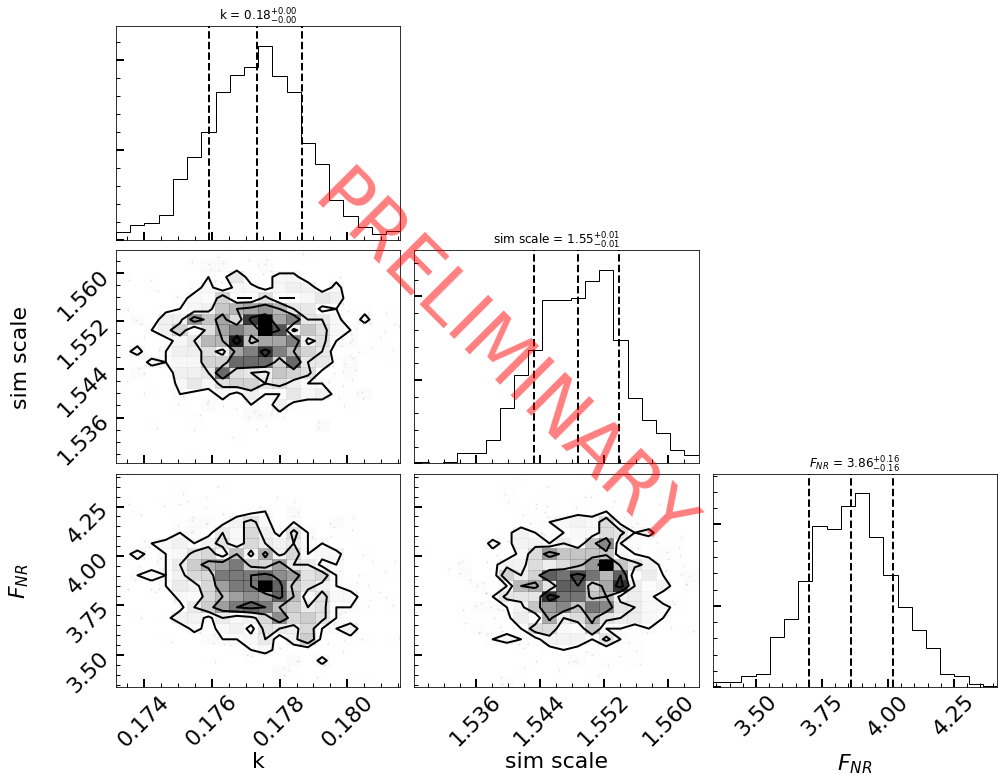

In [76]:
#Make the corner plot
import corner

fig_w=15
fig,ax = plt.subplots(ndim_l,ndim_l,figsize=(fig_w, fig_w*(.75)))

fig = corner.corner(
    flat_samples_l, labels=labels_l, quantiles=[0.16, 0.5, 0.84], show_titles=True, fig=fig
);

fig.text(0.3, 0.3, 'PRELIMINARY', color='r', rotation=-45, fontsize=75, alpha=0.5)
plt.savefig('figures/mcmc/mcmc_lind_norm_5000step_corner.png')

In [45]:
#Calculate the median and 1-sigma equivalent uncertainties
from IPython.display import display, Math

for i in range(ndim_l):
    mcmc = np.percentile(flat_samples_l[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{+{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels_l[i])
    txt=txt.replace('$','')
    #print(txt)
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [56]:
from scipy.optimize import fsolve
def ERtoNR(ER,Y,V,eps):
    func = lambda NR : NR-ER*(1+V/eps)/(1+Y.calc(NR)*V/eps)
    NR_guess = ER
    return fsolve(func, NR_guess)

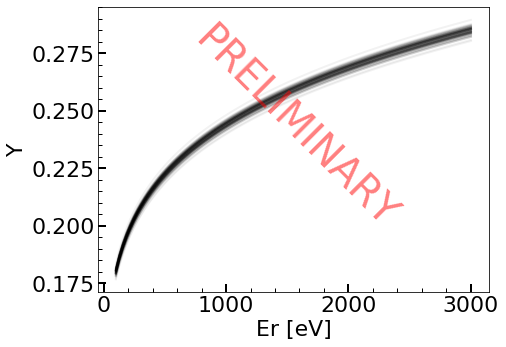

In [77]:
#Plot best fit yield
import R68_yield as Yield
Y=Yield.Yield('Lind',[0.2])

fig_w=7
fig,ax = plt.subplots(1,1,figsize=(fig_w, fig_w*(.75)))

#TODO: Choose appropriate range!
#TODO: Add other measurements from lit
Er_plot=np.linspace(100,3e3,100)

inds = np.random.randint(len(flat_samples_l), size=100)
for ind in inds:
    thetai = flat_samples_l[ind][0]
    Y=Yield.Yield('Lind',[thetai])
    plt.plot(Er_plot, Y.calc(Er_plot), 'k', alpha=0.05)

ax.set_xlabel('Er [eV]')
ax.set_ylabel('Y')
#ax.set_ylim(0.1,0.3);

fig.text(0.3, 0.3, 'PRELIMINARY', color='r', rotation=-45, fontsize=40, alpha=0.5)
plt.savefig('figures/mcmc/mcmc_lind_norm_5000step_yield.png')

# Show best fit spectrum

In [78]:
#Load the data
import R68_load as r68

meas=r68.load_measured()
g4=r68.load_G4()
cap=r68.load_simcap()

Loading Measured Data...
(480634,)
(174510,)
Loading Geant4 Data...
(528848, 7)
(129555, 7)
Loading NRs...
1.5  min
Loading ERs...
0.4  min
Loading (n,gamma) Data...
200000


In [84]:
#Energy binning
Emax = 2000 #eVee
Ebins=np.linspace(0,Emax,201)
Ebin_ctr=(Ebins[:-1]+Ebins[1:])/2

#Measured spectra
N_meas_PuBe,_ = np.histogram(meas['PuBe']['E'],bins=Ebins)
N_meas_Bkg,_ = np.histogram(meas['Bkg']['E'],bins=Ebins)


R_meas = N_meas_PuBe/meas['PuBe']['tlive']-N_meas_Bkg/meas['Bkg']['tlive']
dR_meas = np.sqrt( N_meas_PuBe/(meas['PuBe']['tlive']**2) + N_meas_Bkg/(meas['Bkg']['tlive']**2) )

In [85]:
#Check the best fit results
pars=np.zeros(ndim_l)
for i in range(ndim_l):
    pars[i]=np.percentile(flat_samples_l[:, i], 50)
print(pars)

[0.17733512 1.54875624 3.8608869 ]


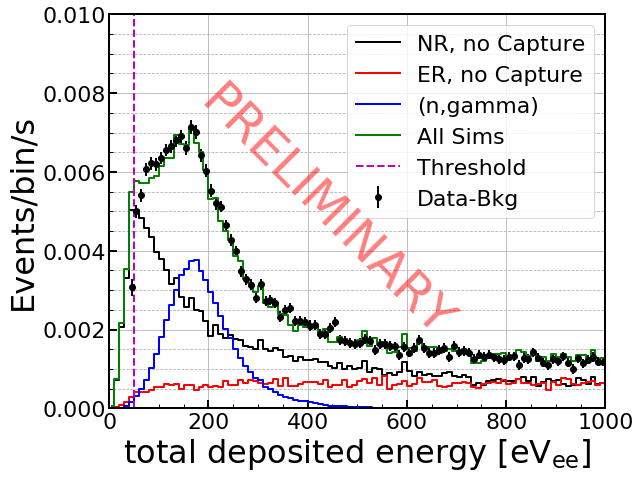

In [92]:
import R68_spec_tools as spec

Y.model='Lind'
#Lindhard
Y.pars=pars[:1]
F_NR=pars[2]
scale_g4=pars[1]
scale_ng=scale_g4

NR,ER,NG=spec.buildSimSpectra_ee(Ebins=Ebins, Evec_nr=g4['NR']['E'], Evec_er=g4['ER']['E'], Evec_ng=cap['E'], dEvec_ng=cap['dE'],
                                 Yield=Y, F_NR=F_NR, scale_g4=scale_g4, scale_ng=scale_ng, doDetRes=True, seed=1)
spec.plotSpectra(E_bins=Ebins, N_nr=NR/g4['NR']['tlive'], N_er=ER/g4['ER']['tlive'], 
                 N_ng=NG/cap['tlive'], N_meas=R_meas, dN_meas=dR_meas , 
                 yrange=(0,1e-2), thresh=Ebins[5])

plt.gcf().text(0.3, 0.3, 'PRELIMINARY', color='r', rotation=-45, fontsize=50, alpha=0.5)
plt.savefig('figures/mcmc/mcmc_lind_norm_5000step_spectrum.png')